# Titanic Analysis: Collide with destiny

![](https://i.imgur.com/rE1OxtK.png)

## Table of Contents
- [Overview](#overview)
- [Wrangling Data](#wranglingData)
- [Developing Model](#developingModel)
- [Validating Model](#validatingModel)
- [Conclusion](#conclusion)
> <B>NOTE</B>: This is my first Kaggle comptition kernel. Any feedback or suggestions will be warmly appreciated. 

----
<a id='overview'></a>
## Overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the `ground truth`) for each passenger. Your model will be based on `features` like passengers’ gender and class. You can also use feature engineering to create new [features](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/).

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

> ### Variable Notes
**pclass**: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>
**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>
**sibsp**: The dataset defines family relations in this way... <br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>
**parch**: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
# importning libraries
import pandas as pd
import numpy as np

#data visualization library 
import seaborn as sns 
import matplotlib.pyplot as plt

# models libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading csv file
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

----
<a id='wranglingData'></a>
## Wrangling Data

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


From above we can see that, Name, Sex, Ticket, Cabin, Embarked colunms have Object (String) values. 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have total, 2 columns float type, 5 columns have integer values and 5 columns have object values.

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From above we can see that Age column have 177 missing values, also gender do not have any numeric values. <br> Adding numerica values to the gender.

In [7]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

We have added numerica values to the `Sex` column, now, adding null values to the `Age` column.

In [8]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [9]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [10]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Same as `Sex` columns we can add numeric values to the `Embarked` columns, This column have 3 values, S, C and Q.

In [11]:
common_value = 'S'
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [12]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [13]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [14]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [15]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [16]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,1,0,3,0,22,1,0,7,0,1,0,8,1,66,3
1,2,1,1,1,38,1,0,71,1,1,0,3,3,38,35
2,3,1,3,1,26,0,0,7,0,0,1,8,2,78,7
3,4,1,1,1,35,1,0,53,0,1,0,3,3,35,26
4,5,0,3,0,35,0,0,8,0,0,1,8,1,105,8


In [17]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [18]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,892,3,0,22,0,0,7,2,0,1,8,1,66,7
1,893,3,1,38,1,0,7,0,1,0,8,3,114,3
2,894,2,0,26,0,0,9,2,0,1,8,1,52,9
3,895,3,0,35,0,0,8,0,0,1,8,1,105,8
4,896,3,1,35,1,1,12,0,2,0,8,3,105,4


In [19]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,3,0,22,1,0,7,0,1,0,8,1,66,3
1,1,1,38,1,0,71,1,1,0,3,3,38,35
2,3,1,26,0,0,7,0,0,1,8,2,78,7
3,1,1,35,1,0,53,0,1,0,3,3,35,26
4,3,0,35,0,0,8,0,0,1,8,1,105,8


In [20]:
Y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [21]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,3,0,22,0,0,7,2,0,1,8,1,66,7
1,3,1,38,1,0,7,0,1,0,8,3,114,3
2,2,0,26,0,0,9,2,0,1,8,1,52,9
3,3,0,35,0,0,8,0,0,1,8,1,105,8
4,3,1,35,1,1,12,0,2,0,8,3,105,4


Upto now we have done wrangling with dateset, Both `X_train` and `X_test` contains similar rows.

----
<a id='developingModel'></a>
## Developing Model

In [22]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

0.9764309764309764

In [23]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X_train, Y_train)
Y_prediction = logisticRegression.predict(X_test)
logisticRegression.score(X_train, Y_train)

0.8159371492704826

In [24]:
xgBoost = XGBClassifier()
xgBoost.fit(X_train, Y_train)
Y_prediction = xgBoost.predict(X_test)
xgBoost.score(X_train, Y_train)

0.8866442199775533

----
<a id='validatingModel'></a>
## Validating Model

I have evaluated 3 models and it's score. You can see from above score that random forest classifier is the best model  out of 3 for the dataset.

In [25]:
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

97.64 %


In [26]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

0.9764309764309764

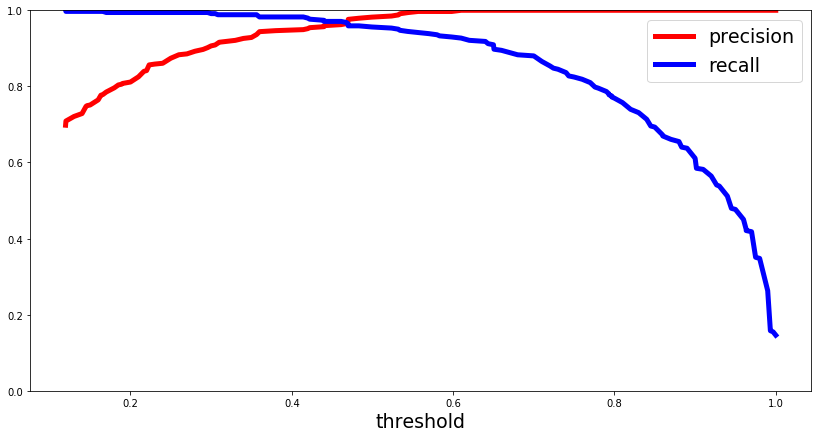

In [27]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

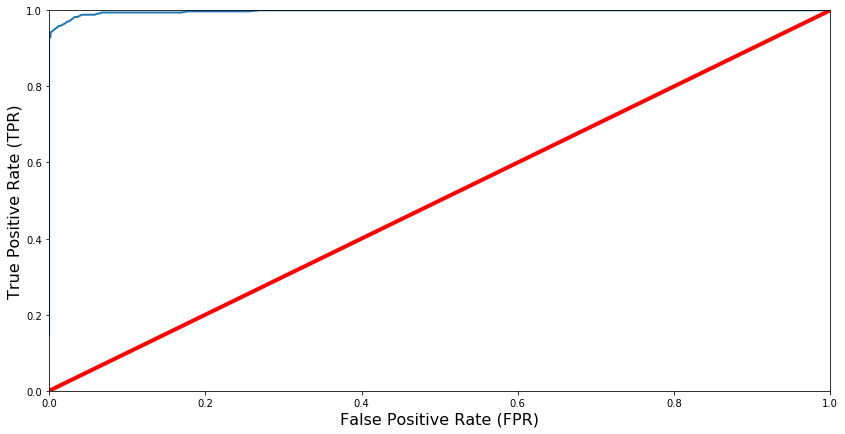

In [28]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9974088986887376


----
<a href='conclusion'></a>
## Conclusion
Here I have implemented three ML algorithms and found the best model *random forest regression*.<br>

#### Inspired from the [End to End Project](https://www.kaggle.com/niklasdonges/end-to-end-project-with-python) with Python and it's Medium article [Predicting the survival of titanic passengers](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8).

What will be in next version
- Improvement accuracy of model
- Explanatory analysis

To know more about me go to my website [https://krunal3kapadiya.app/](https://krunal3kapadiya.app/ )  <br>
If you like this kernel, don't forgot to **upvote** it.